In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import os
import tensorflow as tf
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
import utils
from model import DSFANet

In [14]:
def main(X, Y, GT, diff):

    train_num = 2000
    max_iters = 2000
    lr = 1e-4

    index = np.argsort(diff)
    XData = X[index[0:train_num], :]
    YData = Y[index[0:train_num], :]
    tf.compat.v1.disable_eager_execution()
    inputX = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, X.shape[-1]])
    inputY = tf.compat.v1.placeholder(dtype=tf.float32, shape=[None, Y.shape[-1]])
    model = DSFANet(num=train_num)
    loss = model.forward(X=inputX, Y=inputY)

    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr).minimize(loss)
    init = tf.compat.v1.global_variables_initializer()

    gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
    conf = tf.compat.v1.ConfigProto(gpu_options=gpu_options)
    sess = tf.compat.v1.Session(config=conf)

    sess.run(init)

    train_loss = np.zeros(max_iters)

    for k in range(max_iters):

        _, train_loss[k] = sess.run([optimizer, loss], feed_dict={inputX: XData, inputY: YData})

        if k % 100 == 0:
            print('iter %4d, loss is %.4f' % (k, train_loss[k]))

    XTest, YTest = sess.run([model.X_, model.Y_], feed_dict={inputX: X, inputY: Y})

    sess.close()

    X_trans, Y_trans = utils.SFA(XTest, YTest)

    diff = X_trans-Y_trans
    diff = diff / np.std(diff, axis=0)

    plt.imsave('DSFAdiff.png', (diff**2).sum(axis=1).reshape(GT.shape), cmap='gray')

    bin = KMeans(n_clusters=2).fit((diff**2).sum(axis=-1, keepdims=True)).labels_
    # print(type(bin))
    #bin = KMeans(n_clusters=2).fit(diff).labels_
    plt.imsave('DSFACD.png', bin.reshape(GT.shape), cmap='gray')
    #diff = abs(diff)
    #plt.imsave('DSFAcolor.png',(diff/diff.max()).reshape(GT.shape[0], GT.shape[1],3))

    print(accuracy_score(GT.reshape(-1, 1), bin))
    print(accuracy_score(GT.reshape(-1, 1), 1-bin))

    return True


In [15]:
if __name__ == '__main__':
    
    X, Y, GT = utils.load_dataset()
    diff = utils.cva(X,Y)
    plt.imsave('cva_diff.png', np.reshape(diff, GT.shape), cmap='gray')
    main(X, Y, GT, diff)

c:\proj1\DSFANet\model.py:52: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  X = tf.compat.v1.layers.dense(inputs=X, units=self.hidden_num, activation=self.activation, use_bias=True,)
c:\proj1\DSFANet\model.py:53: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  Y = tf.compat.v1.layers.dense(inputs=Y, units=self.hidden_num, activation=self.activation, use_bias=True,)
c:\proj1\DSFANet\model.py:55: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.X_ = tf.compat.v1.layers.dense(inputs=X, units=self.output_num, activation=self.activation, use_bias=True,)
c:\proj1\DSFANet\model.py:56: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  self.Y_ = tf.compat.v1.la

iter    0, loss is 29.1739
iter  100, loss is 6.9682
iter  200, loss is 4.6170
iter  300, loss is 3.7663
iter  400, loss is 3.2999
iter  500, loss is 2.9889
iter  600, loss is 2.7561
iter  700, loss is 2.5682
iter  800, loss is 2.4089
iter  900, loss is 2.2686
iter 1000, loss is 2.1415
iter 1100, loss is 2.0238
iter 1200, loss is 1.9127
iter 1300, loss is 1.8068
iter 1400, loss is 1.7064
iter 1500, loss is 1.6120
iter 1600, loss is 1.5241
iter 1700, loss is 1.4437
iter 1800, loss is 1.3711
iter 1900, loss is 1.3061
0.11426471774374232
0.8857352822562576


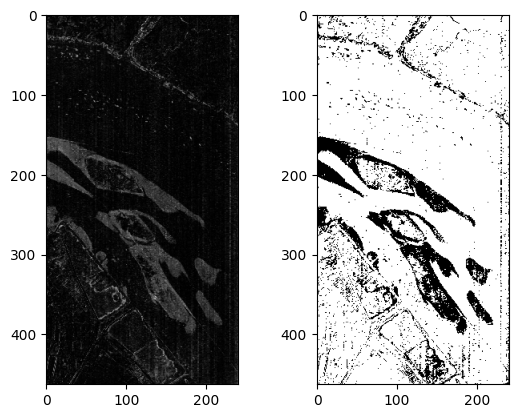

In [25]:
DSFAdiff = plt.imread('DSFAdiff.png')
DSFACD = plt.imread('DSFACD.png')
plt.subplot(121)
plt.imshow(DSFAdiff)
plt.subplot(122)
plt.imshow(DSFACD)
plt.show()

In [2]:
from scipy import io as sio
im = sio.loadmat("river/river_before.mat")['im']
im1 = im[0,0,:]